# 01_PyTorch_Workflow

* Explore an example PyTorch end-to-end workflow.
  

<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/01_a_pytorch_workflow.png" width=900 alt="a pytorch workflow flowchat"/>

In [1]:
import torch
from torch import nn # nn module contains all neural network modules and layers
import matplotlib.pyplot as plt

# Check PyTorch version and GPU availability
print(f"PyTorch version: {torch.__version__}")

PyTorch version: 2.8.0+cu128


## 1. Data (preparing and loading)

Data can be almost anything... in machine learning.

Machine learning is a game of two parts:
1. Get data into a numerical representation;
2. Build a model to learn patterns in that numerical representation;

Use a linear regression formula to make a straight line with known **parameters**.

In [2]:
# Create known parameters
weight = 0.7
bias = 0.3

# Create data
start = 0
end = 1
step = 0.02
x = torch.arange(start, end, step).unsqueeze(dim=1)  # shape (50,) -> (50, 1)
y = weight * x + bias

x[:10], y[:10]  # first 10 samples


(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

### Splitting data into training and test sets (one of the most important concepts in machine learning in general)

Create a training and test data set with our data.

In [3]:
# Create a train and test split
train_split = int(0.8 * len(x)) # 80% for training and 20% for testing.
x_train, y_train = x[:train_split], y[:train_split]
x_test, y_test = x[train_split:], y[train_split:]

len(x_train), len(x_test), len(y_train), len(y_test)

(40, 10, 40, 10)

In [4]:
def plot_predictions(train_data=x_train,
                     train_labels=y_train,
                     test_data=x_test,
                     test_labels=y_test,
                     predictions=None):
    """
    Plots training data, test data and compares predictions to ground truth labels.
    """
    plt.figure(figsize=(10, 7))
    # Plot training data in blue
    plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")
    # Plot test data in green
    plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")

    # Are there predictions?
    if predictions is not None:
        # Plot the predictions if they exist
        plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")

    # Show the legend
    plt.legend(prop={"size": 14});

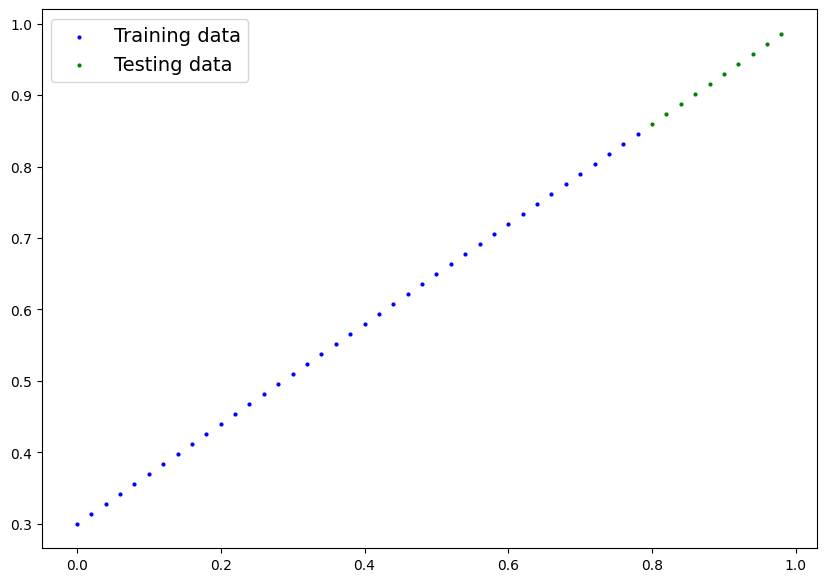

In [5]:
plot_predictions()

## 2. Build model

* What our model does:
  1. start with random values (weigth & bias)
  2. look at training data and adjust the random values to better represent (or get closer to) the ideal values (the weight & bias values we used to create the data)

* How does it do so:
  1. Gradient descent (梯度下降)
  2. Backpropagation (反向传播)

In [6]:
# Create linear regression model class
class LinearRegressionModel(nn.Module): # almost everything in pytorch inherits from nn.Module
    def __init__(self):
        super().__init__()

        # Initialize weights and bias parameters
        self.weights = nn.Parameter(torch.randn(1,  # start with random weights and try to adjust them
                                                requires_grad = True,   # we want to compute gradients with respect to weights
                                                dtype = torch.float32   # data type
                                                ))
        
        self.bias = nn.Parameter(torch.randn(1, # start with random bias and try to adjust it
                                            requires_grad = True,   # we want to compute gradients with respect to bias
                                            dtype = torch.float32   # data type
                                            ))
    
    # Forward method to define the computation performed at every call
    def forward(self, x: torch.Tensor) -> torch.Tensor: # x is input tensor
        return self.weights * x + self.bias # linear regression formula

### PyTorch model building essentials

* torch.nn - contains all of the buildings for computational graphs (a neural network can be considered a computational graph)
* torch.nn.Parameter - what parameters should out model try and learn, often a PyTorch layer from torch.nn will set these for us
* torch.nn.Module - the base class for all neural network modules, if you subclass it, you should overwrite forward()
* torch.optim - this where the optimizer in PyTorch live, they will help with gradient decent
* def forward() - All nn.Module subclasses require you to overwrite forward(), this method defines what happens in the forward computation

### Checking the contents of our PyTorch model

using `.parameters()`

In [7]:
# Create a random seed
torch.manual_seed(42)

# Create an instance of the model (this is a subclass of nn.Module)
model_0 = LinearRegressionModel()

# Check out the model parameters
list(model_0.parameters())  # returns an iterator, so convert to list to see values

[Parameter containing:
 tensor([0.3367], requires_grad=True),
 Parameter containing:
 tensor([0.1288], requires_grad=True)]

In [8]:
# List named parameters
model_0.state_dict()  # state_dict is a Python dictionary object that maps each layer to its parameter tensor

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])

### Making prediction using `torch.inference_mode()`

To check our model's predictive power, test how well it predicts `y_test` based on `x_test`.

When we pass data through our model, it is going to run it through the `forward()` method.

In [9]:
# Make predictions with model
with torch.inference_mode():  # inference mode is used when we are not training the model
    y_preds = model_0(x_test)
# Using with, we don't need to worry about gradients being calculated, saving memory and computations
# Which means much faster.
y_preds, y_test

(tensor([[0.3982],
         [0.4049],
         [0.4116],
         [0.4184],
         [0.4251],
         [0.4318],
         [0.4386],
         [0.4453],
         [0.4520],
         [0.4588]]),
 tensor([[0.8600],
         [0.8740],
         [0.8880],
         [0.9020],
         [0.9160],
         [0.9300],
         [0.9440],
         [0.9580],
         [0.9720],
         [0.9860]]))

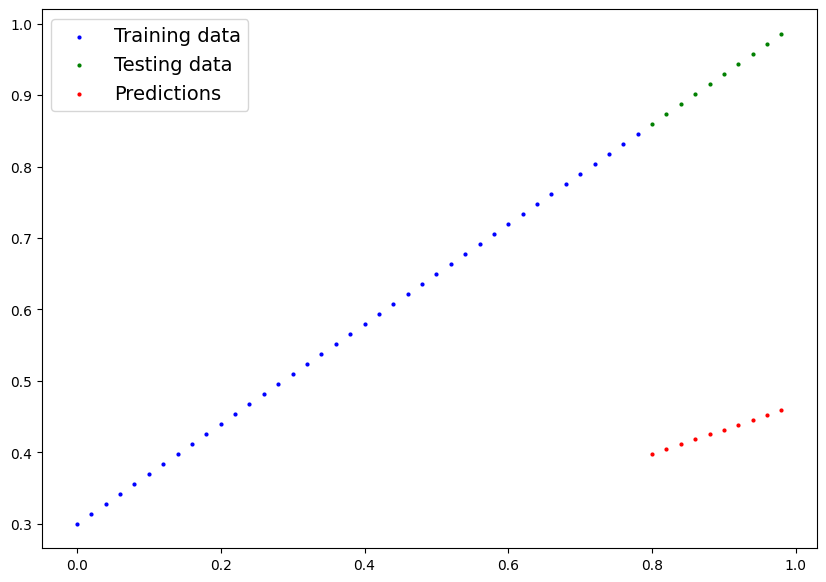

In [10]:
# Plot predictions
plot_predictions(predictions=y_preds)

## 3. Train model

The whole idea of training is for a model to move from some unknown parameters (these may be random) to some known parameters.

Or in other words from a pootr represnetation of the data to a better representation of the data.

One way to measure how poor or how wrong your models predictions are is to use a loss function

* Note: Loss function may also be called cost function or function or criterion in different areas.

Things we need to train:

* **Loss Function**: A function to measure how wrong your model's prediction are to the idea outputs, lower is better.
* **Optimizer**: Takes into account the loss of a model and adjusts the model's parameters (e.g. weigth & bias)

And specifically for PyTorch, we need:
* A training loop
* A testing loop

In [11]:
model_0.state_dict()

OrderedDict([('weights', tensor([0.3367])), ('bias', tensor([0.1288]))])